## Feature Extraction

### Audio Features Extraction MFCC

In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

#### Combining the Directory and File Name 

In [2]:
DATA_DIR = "Court_Room_Data/Train"
video_file = "trial_lie_002.mp4"
video_path = os.path.join(DATA_DIR, video_file)

print("Exists:", os.path.exists(video_path))

Exists: True


#### Extracting the Audio and Computing the MetaData

In [3]:
audio,sr=librosa.load(video_path,sr=None)

sample_rate=sr 
duration=len(audio)/sr

print(f"Sample Rate {sample_rate/1000} kHz Duration {duration} seconds")

/var/folders/sp/zq08zqpj3dl_85f88dk5x16m0000gn/T/ipykernel_54589/3884981144.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  audio,sr=librosa.load(video_path,sr=None)
/Users/lakshyasantani/Desktop/Fake Interview Detection using Multimodal AI/Model Reproduction/deception_detection_ai/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Sample Rate 48.0 kHz Duration 62.44133333333333 seconds


#### Computing the MFCC Score

In [4]:
n_mfcc = 13

mfcc = librosa.feature.mfcc(
    y=audio,
    sr=sr,
    n_mfcc=n_mfcc
)

print("MFCC shape:", mfcc.shape)

MFCC shape: (13, 5854)


#### Visualising the MFCC Cofficients

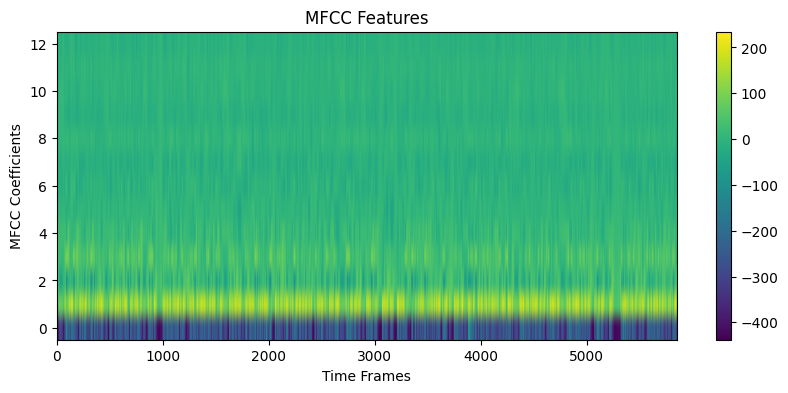

In [5]:
plt.figure(figsize=(10, 4))
plt.imshow(mfcc, aspect="auto", origin="lower")
plt.colorbar()
plt.title("MFCC Features")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.show()


#### Normalising the MFCC Coefficients

In [6]:
mfcc_norm = (mfcc - np.mean(mfcc)) / np.std(mfcc)

In [7]:
print(f"Normalised MFCC Mean {mfcc_norm.mean()} and Standard Deviation {mfcc.std()}")

Normalised MFCC Mean 5.112863465939199e-09 and Standard Deviation 88.6146240234375


### Video Features Extraction (Facial Landmarks)

In [10]:
import cv2
import mediapipe as mp

In [31]:
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

I0000 00:00:1768596853.301660       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2


In [32]:
cap = cv2.VideoCapture(video_path)

landmarks_all_frames = []

frame_count = 0
max_frames = 100   

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = face_mesh.process(rgb)

    if result.multi_face_landmarks:
        face_landmarks = result.multi_face_landmarks[0]
        landmarks = []

        for lm in face_landmarks.landmark:
            landmarks.append([lm.x, lm.y])

        landmarks_all_frames.append(landmarks)

    frame_count += 1

cap.release()


In [13]:
landmarks_array = np.array(landmarks_all_frames)

print("Landmarks shape:", landmarks_array.shape)


Landmarks shape: (100, 468, 2)


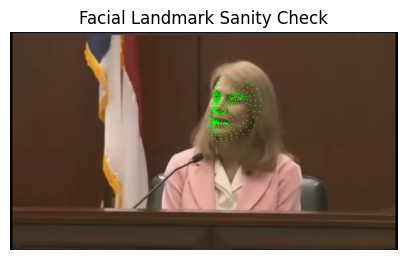

In [14]:
frame_idx = 0

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()
cap.release()

h, w, _ = frame.shape
points = landmarks_array[frame_idx]

for (x, y) in points:
    cx, cy = int(x * w), int(y * h)
    cv2.circle(frame, (cx, cy), 1, (0, 255, 0), -1)

plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Facial Landmark Sanity Check")
plt.show()


In [15]:
mean = landmarks_array.mean(axis=(0,1), keepdims=True)
std = landmarks_array.std(axis=(0,1), keepdims=True)

landmarks_norm = (landmarks_array - mean) / std

In [16]:
os.makedirs("features/video", exist_ok=True)

save_name = video_file.replace(".mp4", ".npy")
save_path = os.path.join("features/video", save_name)

np.save(save_path, landmarks_norm)

print("Saved landmarks to:", save_path)

Saved landmarks to: features/video/trial_lie_002.npy


### Transcripts Extraction

In [18]:
import whisper

model = whisper.load_model("base")  # balanced accuracy & speed


100%|███████████████████████████████████████| 139M/139M [00:22<00:00, 6.32MiB/s]


In [21]:
result=model.transcribe(video_path)

/Users/lakshyasantani/Desktop/Fake Interview Detection using Multimodal AI/Model Reproduction/deception_detection_ai/lib/python3.11/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [24]:
result["text"][:51]

' And she approached me and at that time she tripped'

### Saving all the Features Locally

#### Saving all the Transcripts for all the Videos

In [ ]:
video_dir = "Court_Room_Data/Train"
save_dir = "transcripts/train"
os.makedirs(save_dir, exist_ok=True)

for vid in os.listdir(video_dir):
    if not vid.endswith(".mp4"):
        continue

    vid_path = os.path.join(video_dir, vid)
    print("Transcribing:", vid)

    result = model.transcribe(vid_path)

    txt_path = os.path.join(save_dir, vid.replace(".mp4", ".txt"))
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(result["text"])


In [ ]:
video_dir = "Court_Room_Data/Test"
save_dir = "transcripts/test"
os.makedirs(save_dir, exist_ok=True)

for vid in os.listdir(video_dir):
    if not vid.endswith(".mp4"):
        continue

    vid_path = os.path.join(video_dir, vid)
    print("Transcribing:", vid)

    result = model.transcribe(vid_path)

    txt_path = os.path.join(save_dir, vid.replace(".mp4", ".txt"))
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(result["text"])


#### Saving the Features for all the Videos

In [ ]:
video_dir = "Court_Room_Data/Train"
save_dir = "features/video/train"
os.makedirs(save_dir, exist_ok=True)


for vid in os.listdir(video_dir):
    if not vid.endswith(".mp4"):
        continue
    
    video_path = os.path.join(video_dir, vid)
    cap = cv2.VideoCapture(video_path)

    landmarks_all_frames = []

    frame_count = 0
    max_frames = 100   

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = face_mesh.process(rgb)

        if result.multi_face_landmarks:
            face_landmarks = result.multi_face_landmarks[0]
            landmarks = []

            for lm in face_landmarks.landmark:
                landmarks.append([lm.x, lm.y])

            landmarks_all_frames.append(landmarks)

        frame_count += 1

    cap.release()
    
    if len(landmarks_all_frames) == 0:
        print(f"No face detected in {vid}, skipping")
        continue

    landmarks_array = np.array(landmarks_all_frames)
    
    mean = landmarks_array.mean(axis=0)
    std = landmarks_array.std(axis=0) + 1e-6

    landmarks_norm = (landmarks_array - mean) / std

    save_name = vid.replace(".mp4", ".npy")
    save_path = os.path.join(save_dir, save_name)

    np.save(save_path, landmarks_norm)

    print("Saved landmarks to:", save_path)

#### Saving the Audio Features

In [ ]:
video_dir = "Court_Room_Data/Train"
save_dir = "features/audio/train"
os.makedirs(save_dir, exist_ok=True)


for vid in os.listdir(video_dir):
    if not vid.endswith(".mp4"):
        continue
    
    video_path = os.path.join(video_dir, vid)

    audio,sr=librosa.load(video_path,sr=None)

    n_mfcc = 13

    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc
    )
    
    mfcc_norm = (mfcc - mfcc.mean(axis=1, keepdims=True)) / (
    mfcc.std(axis=1, keepdims=True) + 1e-6
    )
    
    feature_name = vid.replace(".mp4", ".npy")
    save_path = os.path.join(save_dir, feature_name)

    np.save(save_path, mfcc_norm)

    print("Saved MFCC to:", save_path)

In [38]:
video_dir = "Court_Room_Data/Test"
save_dir = "features/audio/test"
os.makedirs(save_dir, exist_ok=True)


for vid in os.listdir(video_dir):
    if not vid.endswith(".mp4"):
        continue
    
    video_path = os.path.join(video_dir, vid)

    audio,sr=librosa.load(video_path,sr=None)

    n_mfcc = 13

    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc
    )
    
    mfcc_norm = (mfcc - mfcc.mean(axis=1, keepdims=True)) / (
    mfcc.std(axis=1, keepdims=True) + 1e-6
    )
    
    feature_name = vid.replace(".mp4", ".npy")
    save_path = os.path.join(save_dir, feature_name)

    np.save(save_path, mfcc_norm)

    print("Saved MFCC to:", save_path)
    
    

/var/folders/sp/zq08zqpj3dl_85f88dk5x16m0000gn/T/ipykernel_54589/2690672988.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio,sr=librosa.load(video_path,sr=None)


Saved MFCC to: features/audio/test/trial_truth_056.npy
Saved MFCC to: features/audio/test/trial_truth_057.npy
Saved MFCC to: features/audio/test/trial_lie_056.npy
Saved MFCC to: features/audio/test/trial_truth_055.npy
Saved MFCC to: features/audio/test/trial_lie_057.npy
Saved MFCC to: features/audio/test/trial_lie_060.npy
Saved MFCC to: features/audio/test/trial_lie_061.npy
Saved MFCC to: features/audio/test/trial_truth_060.npy
Saved MFCC to: features/audio/test/trial_truth_059.npy
Saved MFCC to: features/audio/test/trial_truth_058.npy
Saved MFCC to: features/audio/test/trial_lie_059.npy
Saved MFCC to: features/audio/test/trial_lie_058.npy
